# Logistic Regression

## 1. 기본

### 1.1 개념

- 의미: '독립변수 X를 바탕으로 종속변수 Y를 예측한다'는 점에선 Linear regression과 동일하다. 다른 점은 종속변수 Y가 명목변수, 즉 classification에서 class를 의미한다. 즉 어떤 데이터를 A인지 B인지를 판별
- 수식의 결과로 "이 데이터는 A다!"를 나타낼 수 없으므로 확률을 사용한다. A, B가 될 확률을 각각 계산하고 0.5 이상이면 positive 판별을 한다. 두 개일 때라서 0.5고 3개 이상(multinomial logistic regression)이면 가장 높은 확률을 가진 class로 판별한다.
- Linear regression만을 쓰면 계산 안됨 : Y를 확률, X를 feature로 해서 Linear regression을 해보면 Y값이 0 이하인 경우가 나온다. 확률이 음수인 경우는 없으므로 Y 값을 0에서 1 사이로 제한을 해줄 필요가 있다.
- Logistic function(or Sigmoid function): 제한을 할 때 사용하고 이를 활용한 regression을 Logistic regression이라 한다. 정확히 말하면 Logistic function 중 standard 형태를 Sigmoid function이라 하고 이 형태를 사용하는 것. logistic function의 정의와 속성은 다음과 같다.

\begin{align}
g(x) = {1 \over 1 + e^{-x}} \\
{d \over dx}g(x) = g(x)(1 - g(x)) \\
1 - g(x) = g(-x)
\end{align}

> Logistic function 대신 CDF를 쓸 수도 있는데 이 때는 Probit regression이라고 한다.

### 1.2 Decision boundary

- Decision boundary: Yes와 No를 가르는 기준이 되는 함수, 즉 Classifier이자 Hyperplane이다.

    $f(x) = b_0 + b_1x$

    $g(x) = {1 \over 1 + \exp(-f(x))} = {1 \over 1 + \exp(-(b_0 + b_1x))}$
    
    $P(Y=Yes) = g(f(x)) = {1 \over 1 + \exp(-f(x))} = {1 \over 1 + \exp(-(b_0 + b_1x))}$
    
    $P(Y=No) = 1 - P(Y=Yes) = 1 - g(f(x)) = g(-f(x)) = {1 \over 1 + \exp(b_0 + b_1x)}$

- Log odds 사용한다. $log \frac{P(Y=Yes)}{P(Y=No)}$ 식이 0보다 크면 yes다.
- 위 Log odds를 풀어쓰면 결국 **f(x)**로 유도되고 0보다 크면 Yes다.

    $log \frac{g(f(x))}{g(-f(x))}$
    
    $log \frac{1 + exp(f(x))}{1 + exp(-f(x))}$
    
    $log \exp(f(x))$
    
    $f(x)$

### 1.3 Squared loss

- Decision boundary는 결국 `f(x)`, `b0 + b1*x`가 되는 것을 확인했다. 이제 가장 적합한 b0, b1을 알아내야한다.
- Linear regression에서 사용했던 Squared loss를 쓰면 어떻게 될까. 실제 Y값과 `g(f(x))`의 값의 차이를 제곱한 것을 모두 합한 RSS의 추이를 구해보겠다.

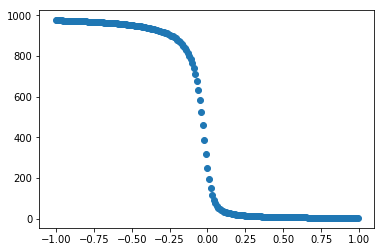

In [1]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


def f(x, coef):
    return coef * x

def g(x, coef):
    return 1 / (1 + math.exp(-f(x, coef)))

X_rss = np.arange(-50, 50, 0.1)
Y_rss = np.array([0 if x < 0 else 1 for x in np.arange(-50, 50, 0.1)])

costs = []
for coef in np.arange(-1, 1, 0.01):
    c = 0
    for i in range(len(X_rss)):
        c += (Y_rss[i] - g(X_rss[i], coef)) ** 2
    costs.append(c)

plt.scatter(np.arange(-1, 1, 0.01), costs)
plt.show()

- `f(x)`는 intercept가 없는 단순한 `y = b*x` 꼴을 취했다. 그리고 coefficient의 변화에 따라 RSS가 어떻게 달라지는지 그래프를 그렸다.
- coefficient b가 음수로 갈수록 RSS는 커지고, 양수로 갈수록 RSS는 작아진다.
- 최적의 b를 찾아야하는 상황에서 cost가 수렴하지 않는 non-convex 그래프이고 Gradient descent 알고리즘을 적용해서 구할 수 없다.
- 직관적으로 살펴보면
    + b가 음의 방향으로 커진다는 것은 0, 1 값으로 이루어진 Y와 완전히 반대 방향으로 그래프가 그려진다는 의미이고 cost가 커지는 것이다.
    + 반대로 양의 방향은 Y의 값을 정확히 맞추는 방향으로 그래프가 급격히 기울어지는 것이며 cost가 낮아진다.
    + 즉 기울기의 절대값이 커지면 Yes, No의 경계면에서 굉장히 급격하게 거의 y축과 평행으로 솟구치는 것이고 계단함수와 유사하게 된다.
    + 그렇게되면 기울기가 커지면 커질수록 좋은 것이고 수렴도 안 할 뿐더러, 현재 1개의 feature라고 했을 때 hyperplane은 특정 스칼라값의 점이 되는데 결국 `intercept / infinite`이 되어 0이 된다. 말이 안된다.
- 결론은 쓸 수 없다라는 것.

### 1.4 Maximum likelihood

> likelihood의 개념은 [김진섭님의 글](http://rstudio-pubs-static.s3.amazonaws.com/204928_c2d6c62565b74a4987e935f756badfba.html)을 보고 이해했다. 최고로 자세하고 체계적인 설명!

- Squared loss 대신 Likelihood를 사용하고 최대화하는 방향으로 b0, b1을 계산한다.
    + 정의: 어떤 확률변수에서 표집한 값들을 토대로 그 확률변수의 모수를 구하는 방법. 또는 어떤 모수가 주어졌을 때 원하는 값들이 나올 가능도를 최대로 만드는 모수를 선택하는 방법을 말한다.
    + 계산 방법: 모든 데이터에 대해서 각각 일어날 확률들을 모두 곱한 값이 likelihood이고 최대화한다.
    + 다음 수식의 값을 최대화
    
$$
\prod_{i=1}^NP(Y\ |\ X_i,\beta_0,\beta_1)
$$

- $L = y_ig(f(x)) + (1 - y_i)(1 - g(f(x)))$
    + Y가 Yes냐 No냐에 따라 확률 식이 `g(f(x))` 또는 `1 - g(f(x))` 으로 달라진다. b0, b1 값을 계산할 때 매번 수식을 바꾸기는 귀찮으므로 수식을 위처럼 각 수식 앞에 해당 데이터의 y값(yi)을 곱해주는 것으로 변경한다.
    + Y가 Yes일 때는 y를 1, No일 때는 y를 0으로 하면 위 식으로 Y가 Yes든 No든 적용 가능해진다.
- Maximum log likelihood: log를 씌우면 곱셈을 덧셈으로 바꿀 수 있어서 연산이 쉬워지고 작은 값들에 대한 연산도 가능해진다.
    + $\log(L) = y_i\times\log(g(f(x))) + (1 - y_i)\times\log(1 - g(f(x)))$
- 여기서 -1을 곱하게 되면 최소값을 구하는 문제로 바뀐다.
    + $\text{argmin}_{b0, b1}\ -\log L(b0,b1|X, Y)$
- Linear regression에서처럼 Gradient descent 알고리즘을 활용해서 최적의 b0, b1 값을 찾는다.
- income이라는 feature를 추가해서 b0, b1, b2를 구하게 되더라도 decision boundary는 f(x)로 같다.

### 1.5 데이터

```
   Unnamed: 0  default  student      balance       income
0           1        0        0   729.526495  44361.62507
1           2        0        1   817.180407  12106.13470
2           3        0        0  1073.549164  31767.13895
3           4        0        0   529.250605  35704.49394
4           5        0        0   785.655883  38463.49588
```

- 자료
    - `default` : 파산 여부
    - `student` : 학생 여부
    - `balance` : 자산
    - `income` : 수입
- 학생 여부, 자산, 수입 데이터를 기반으로 파산 여부를 예측해본다.
- 나중에 검증할 때는 K-fold cross validation 기법을 활용
    + k가 5라면 전체 데이터를 5개로 쪼개고 4개는 학습, 1개는 test로 활용한다.
    + 5개가 각각 test를 한 번씩 해보도록 돌려가면서 같은 모델을 테스트.

## 2. Simple Logistic Regression

Independent variable: Balance
Linear Coefficients: [ 0.00061851]
Linear Intercept: -0.2849174862797101
Logistic Coefficients: [[ 0.00437833]]
Logistic Intercept: [-5.58917553]
Score: 0.84328358209


/Users/qbinson/.virtualenvs/python-ml/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


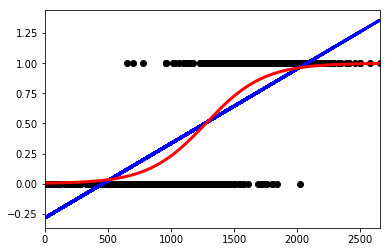

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import pandas as pd


def main():
    data = pd.read_csv("./Default.csv", header=0)
    response_var = 1
    y_vec = data.ix[:, response_var].as_matrix().squeeze()
    x_vec = data.ix[:, 3].as_matrix().reshape(-1, 1)

    one_var_default(x_vec, y_vec)


def one_var_default(x_vec, y_vec, rs=108):
    x_train, x_test, y_train, y_test = train_test_split(x_vec, y_vec, test_size=0.2, random_state=rs)

    regr_linear = linear_model.LinearRegression()
    regr_linear.fit(x_train, y_train)

    regr_logistic = linear_model.LogisticRegression()
    regr_logistic.fit(x_train, y_train)
    
    score = regr_logistic.score(x_test, y_test)

    print("Independent variable: {}".format("Balance"))
    print("Linear Coefficients: {}".format(regr_linear.coef_))
    print("Linear Intercept: {}".format(regr_linear.intercept_))
    print("Logistic Coefficients: {}".format(regr_logistic.coef_))
    print("Logistic Intercept: {}".format(regr_logistic.intercept_))
    print("======\nScore:", score)

    x_minmax = np.arange(x_vec.min(), x_vec.max()).reshape(-1, 1)
    plt.plot(x_vec, regr_linear.predict(x_vec), color='blue', linewidth=3)
    plt.plot(x_minmax, regr_logistic.predict_proba(x_minmax)[:, 1], color='red', linewidth=3)
    plt.scatter(x_vec, y_vec, color='black')

    plt.xlim((x_vec.min(), x_vec.max()))

    # filename = "default_logit_fig.png"
    # plt.savefig(filename)
    plt.show()
    plt.close()


if __name__ == "__main__":
    main()


- 실제 데이터 분포와 Linear, Logical regression 그래프를 모두 그렸다. X는 balance, Y는 파산 여부(default)이다.
- black dots: 실제 데이터 분포다. balance에 대한 파산 여부를 점으로 찍음
- blue line
    + `plt.plot(x_vec, regr_linear.predict(x_vec), color='blue', linewidth=3)`
    + X 값과 Linear regression 모델의 predict 값을 활용해서 직선 긋기
- red line:
    + `x_minmax = np.arange(x_vec.min(), x_vec.max()).reshape(-1, 1)` : x의 최소값에서부터 최대값까지의 모든 자연수를 벡터화
    + `plt.plot(x_minmax, regr_logistic.predict_proba(x_minmax)[:, 1], color='red', linewidth=3)`
    + 모든 x 범위의 자연수에 대해서 Logistic regression 모델의 예측값을 그래프로 그림
- coefficient, intercept
    + Linear에선 regression line의 coefficient와 intercept
    + Logistic에선 `b0 + b1*x` 값이 0 이상일 때 Yes로 분류하겠다는 decision boundary를 의미
- 예측 정확도
    + `score = regr_logistic.score(x_test, y_test)`
    + train, test 데이터를 분리하고 학습한 모델을 test 데이터에 적용.
- 결론은 이런 상황에서는 Linear regression이 큰 힘을 발휘하지 못한다라는 것. Logistic을 써야한다.

## 3. Multiple Logistic Regression

simple logistic regression에서와 방식은 똑같고 X 값으로 vector가 아닌 matrix 형태의 데이터를 넣어주면 된다.

In [3]:
from sklearn import linear_model
import pandas as pd
from sklearn.model_selection import train_test_split


def main():
    data = pd.read_csv("./Default.csv", header=0)
    response_var = 1
    y_vec = data.ix[:, response_var].as_matrix().squeeze()
    x_mat = data.ix[:, range(2, 5)].as_matrix().reshape(-1, 3)

    multi_var_default(x_mat, y_vec)


def multi_var_default(x_mat, y_vec, rs=108):
    x_train, x_test, y_train, y_test = train_test_split(x_mat, y_vec, test_size=0.2, random_state=rs)

    regr_logistic = linear_model.LogisticRegression()

    regr_logistic.fit(x_train, y_train)

    score = regr_logistic.score(x_test, y_test)

    print("Indepedent variables: {}".format("ALL"))
    print("Coefficients: {}".format(regr_logistic.coef_))
    print("Intercept: {}".format(regr_logistic.intercept_))
    print("Accuracy: {}".format(score))


if __name__ == "__main__":
    main()

Indepedent variables: ALL
Coefficients: [[ -1.72292013e+00   3.72892638e-03  -7.73316052e-05]]
Intercept: [-1.47626442]
Accuracy: 0.8507462686567164


## 4. Multi-class classifier

- "1 대 나머지"(one-vs-rest) 접근법을 활용한다.
- A, B, C, D 클래스가 있으면 A냐 아니냐, B냐 아니냐, C냐 아니냐, D냐 아니냐를 분류하는 4개의 binary classifier를 만든다.
- 즉 K개의 클래스가 있으면 K개의 binary classifier를 만드는 것.
- 테스트할 데이터를 모든 K개의 binary classifier로 돌려보고 가장 높은 확률이 나오는 class를 선택한다.

### 4.1 Library, Dataset

In [1]:
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
import numpy as np

def load_data():
    return datasets.load_iris(return_X_y=True)

- iris 데이터를 사용한다. 꽃의 특징을 3개의 클래스(setosa, versicolor, virginica)로 구분하고자 한다.
- `return_X_y=True` : 데이터셋과 label을 분리해서 리턴하는 옵션

### 4.2 Binary classifier

In [7]:
def binary_classification(X, binary_label):
    lr = LogisticRegression()
    lr.fit(X, binary_label)
    return lr.predict_proba(X)[:, 1]

- X : 처음 데이터셋에서 X, y로 분리했을 때 받은 X 데이터다.
- binary_label : 판별하고자 하는 대상이냐 아니냐를 1과 0으로 표한 1차원 벡터다. 1일 확률을 다시 벡터에 담아 리턴할 것이다.
- Logistic regression을 활용해서 둘 중 하나로 분리한다.
- `lr.predict_proba(X)`
    + 여기선 편의상 학습한 데이터를 그대로 예측할 때도 사용했다.(원래는 이러면 안됨)
    + 0인지, 1인지에 대한 확률이 각 데이터 row마다 계산된다.
    + `[[0.1, 0.9], [0.2, 0.8], ...]`의 형태다.
- 1인 확률을 리턴해야하니 1번 인덱스 컬럼만 잘라서 리턴한다.

### 4.3 Multi-class Classifier

In [8]:
def multiclass_classification(X, y):
    label_0 = np.array([1 if x == 0 else 0 for x in y])
    label_1 = np.array([1 if x == 1 else 0 for x in y])
    label_2 = np.array([1 if x == 2 else 0 for x in y])
    
    p_0 = binary_classification(X, label_0)
    p_1 = binary_classification(X, label_1)
    p_2 = binary_classification(X, label_2)
    
    result = []
    for i in range(len(p_0)):
        tmp = [p_0[i], p_1[i], p_2[i]]
        result.append(tmp.index(max(tmp)))
    result = np.array(result)
    
    accuracy = sum(result == y) / len(y)
    return accuracy

- 우선 binary label을 각 클래스마다 만든다. 0인지 아닌지, 1인지 아닌지, 2인지 아닌지.
- 각각의 binary label을 활용해 binary classification을 시행한다. 해당 데이터셋이 0일 확률, 1일 확률, 2일 확률이 계산되어서 저장될 것이다.
- 계산된 확률 벡터들을 row 별로 비교해서 가장 높은 확률값을 result에 저장한다.
- accuracy는 전체 데이터에서 잘 맞춘 raw의 개수의 비율이다.

### 4.4 Main

In [9]:
def main():
    data = load_data()
    accuracy = multiclass_classification(data[0], data[1])
    print("accuracy:", accuracy)
    return

if __name__ == '__main__':
    main()

accuracy: 0.96


## 5. Ensemble classifier

- 여러 개의 classifier를 함께 사용해서 클래스를 분류하는 방법이다.
- 예를 들어 classifier가 3개 있다면 각각에 가중치를 주고, 각 classifier가 분류한 클래스의 확률값에 곱해서 비교한다.

|classifier|class1|class2|class3|
|-----|-----|-----|-----|
|classifier 1|w1 * 0.2 | w1 * 0.5 | w1 * 0.3|
|classifier 2|w2 * 0.6 | w2 * 0.3 | w2 * 0.1|
|classifier 3|w3 * 0.3 | w3 * 0.4 | w3 * 0.3|
|weighted average|0.37|0.4|0.23|

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn import datasets

def Ensemble_clf(clfs, X, w):
    probs = [clf.predict_proba(X) for clf in clfs]
    result = []
    for i in range(len(X)):
        tmp = probs[0][i, :] * w[0] + \
            probs[1][i, :] * w[1] + \
            probs[2][i, :] * w[2]
        result.append(list(tmp).index(max(tmp)))
    return np.array(result)

def main():
    np.random.seed(123)

    iris = datasets.load_iris()
    X, y = iris.data[:, 1:3], iris.target
    
    random_idx = np.random.permutation(np.arange(len(y)))
    X = X[random_idx]
    y = y[random_idx]
    
    clf1 = LogisticRegression(C = 1)
    clf2 = LogisticRegression(C = 0.5)
    clf3 = GaussianNB()
    clfs = [clf1, clf2, clf3]
    
    w = [1., 1., 1.]
    kf = KFold(n_splits=5)
    
    result = []
    for train, test in kf.split(X):
        score = []
        
        for clf in clfs:
            clf.fit(X[train], y[train])
            clf_score = clf.score(X[test], y[test])
            score.append(clf_score)
            
        ensemble_clf_score = np.average(y[test] == Ensemble_clf(clfs, X[test], w))
        score.append(ensemble_clf_score)
        
        result.append(score)
        
    print('clf1 score : %.2f\nclf2 score : %.2f\nclf3 score : %.2f\nensemble clf score : %.2f' \
          % tuple(np.average(np.asarray(result), axis = 0).tolist()))

if __name__ == "__main__":
    main()

clf1 score : 0.91
clf2 score : 0.81
clf3 score : 0.91
ensemble clf score : 0.93
